REPOSO

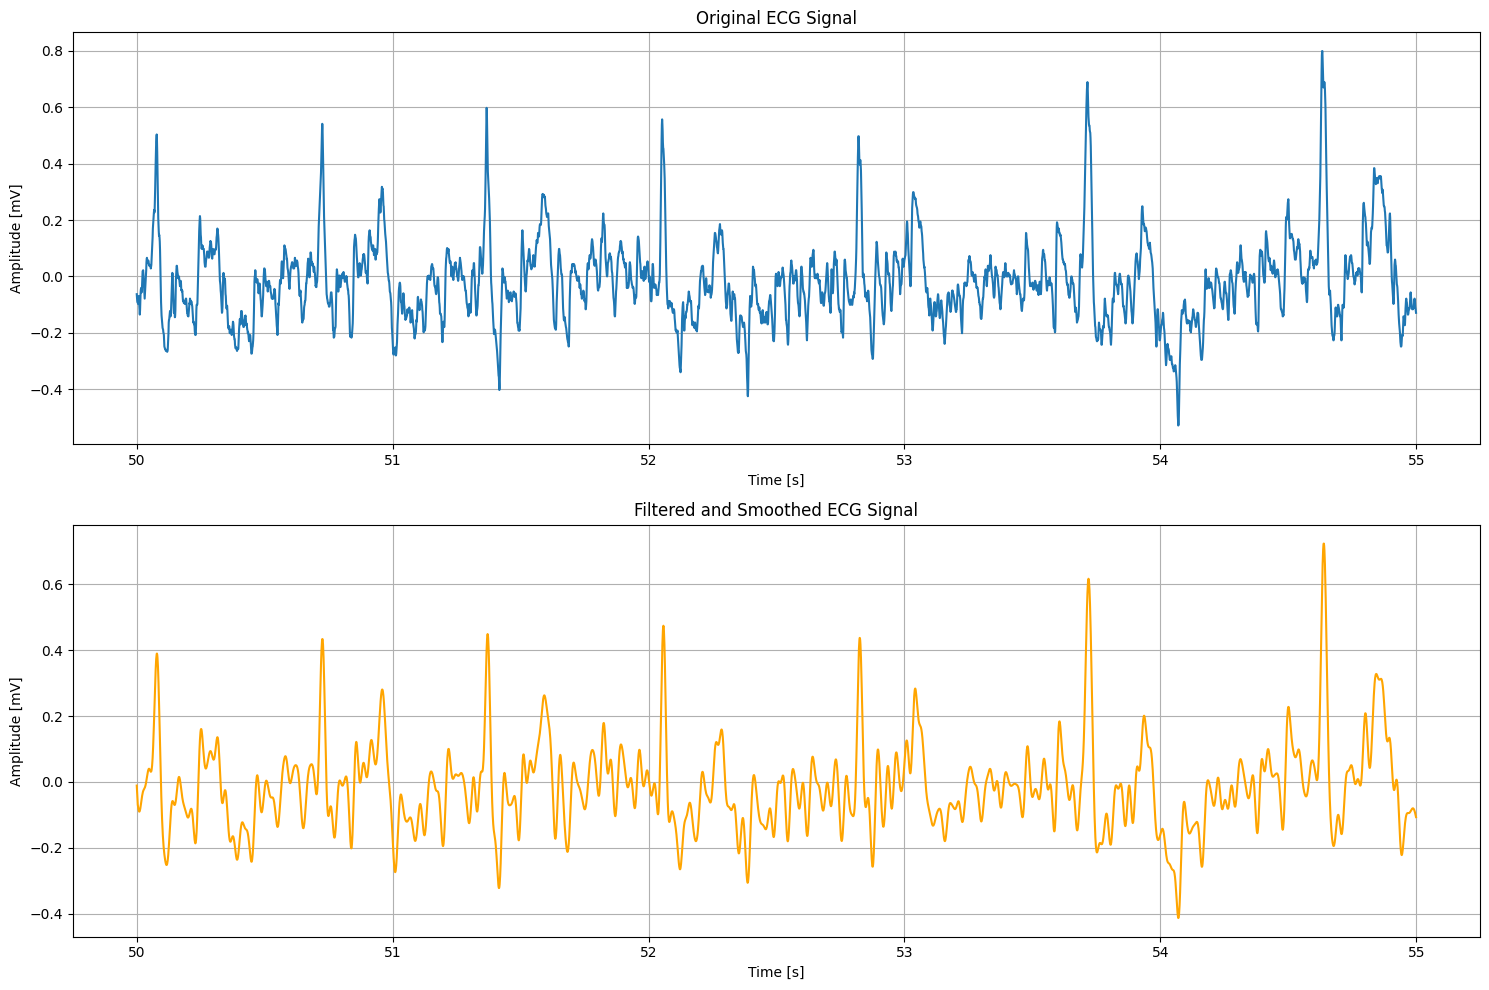

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
from scipy.signal import filtfilt, firwin, lfilter, find_peaks

# URL of the raw text file containing ECG data
url= "https://raw.githubusercontent.com/diego-taquiri/ISB-equipo11/main/Documentaci%C3%B3n/Laboratorio%2006/ecg_raw_data/reposo/opensignals_98D341FD4F0D_2024-04-19_12-34-17.txt"
#url = "https://raw.githubusercontent.com/diego-taquiri/ISB-equipo11/main/Documentaci%C3%B3n/Laboratorio%2006/ecg_raw_data/ejercicio/opensignals_98D341FD4F0D_2024-04-19_12-46-31.txt"
#url= "https://raw.githubusercontent.com/diego-taquiri/ISB-equipo11/main/Documentaci%C3%B3n/Laboratorio%2006/ecg_raw_data/paro_cardiaco/opensignals_98D341FD4F0D_2024-04-19_12-56-28.txt"

# Download the data from the URL
response = urlopen(url)
data = response.read().decode('utf-8').splitlines()

# Load data from the downloaded text file skipping the first 3 rows
x = np.loadtxt(data, skiprows=3)

# Calculate data in millivolts
data_mV = (x[:, 5] / 1024) * 3.223 - 3.223 / 2

# Generate time array in seconds
time = np.arange(len(data_mV)) / 1000

start_index = np.searchsorted(time, 50)  # Find the index corresponding to 50 seconds
end_index = np.searchsorted(time, 55)  # Find the index corresponding to 120 seconds
time = time[start_index:end_index]
data_mV = data_mV[start_index:end_index]

# Bandpass filter design (0.5 Hz to 43 Hz)
fs = 1000  # Sampling frequency
nyquist = 0.5 * fs
low_cutoff = 0.5 / nyquist
high_cutoff = 43 / nyquist

# Design FIR filter
numtaps = 101  # Number of taps in the filter
b = firwin(numtaps, [low_cutoff, high_cutoff], pass_zero=False)

# Apply zero-phase digital bandpass filter
filtered_signal = filtfilt(b, 1, data_mV)

# Moving average filter design
window_size = 5  # Window size for the moving average filter
moving_avg_filter = np.ones(window_size) / window_size

# Apply moving average filter
smoothed_signal = lfilter(moving_avg_filter, 1, filtered_signal)

# Calculate the first derivative
first_derivative = np.diff(smoothed_signal, n=1)
# Append a zero to maintain the original signal length
first_derivative = np.append(first_derivative, 0)

# Calculate the second derivative
second_derivative = np.diff(smoothed_signal, n=2)
# Append two zeros to maintain the original signal length
second_derivative = np.append(second_derivative, [0, 0])

# Combine the derivatives to form the feature signal
feature_signal = 1.3 * first_derivative + 1.1 * second_derivative

# Find the R peaks (maximum peaks) in the feature signal
peaks, _ = find_peaks(feature_signal, distance=fs/2.5, height=0.02)  # Assuming a minimum distance of 0.4 seconds between R peaks

# Extract RR intervals
RR_intervals = np.diff(time[peaks])*1000

# Plot the original, filtered, and feature signals with detected peaks
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(time, data_mV, label='Original Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [mV]')
plt.title('Original ECG Signal')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(time, smoothed_signal, label='Filtered and Smoothed Signal', color='orange')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [mV]')
plt.title('Filtered and Smoothed ECG Signal')
plt.grid()

plt.tight_layout()
plt.show()

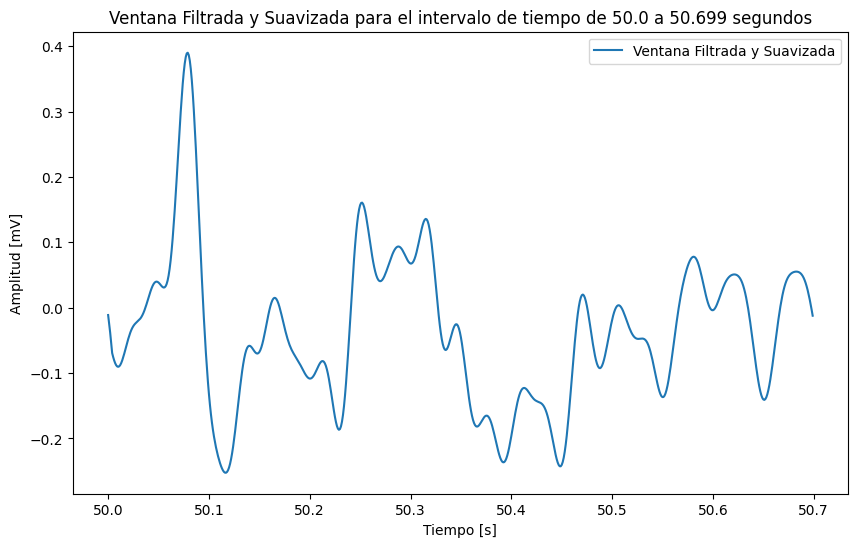

In [49]:
# Definir la duración de cada ventana en segundos y el desplazamiento (overlap)
window_length = 0.7  # longitud de la ventana en segundos
overlap = 0.5      # desplazamiento de la ventana en segundos

# Calcular el número de puntos en cada ventana
window_points = int(window_length * fs)
overlap_points = int(overlap * fs)

# Procesar cada ventana
start = 0
end = start + window_points

# Listas para almacenar resultados
filtered_signals = []
smoothed_signals = []
times = []

while end <= len(data_mV):
    # Extraer la ventana de la señal
    window_signal = data_mV[start:end]
    window_time = time[start:end]

    # Aplicar filtros como antes
    filtered_window = filtfilt(b, 1, window_signal)
    smoothed_window = lfilter(moving_avg_filter, 1, filtered_window)

    # Almacenar las señales procesadas y los tiempos
    filtered_signals.append(filtered_window)
    smoothed_signals.append(smoothed_window)
    times.append(window_time)

    # Desplazar la ventana
    start += (window_points - overlap_points)
    end = start + window_points

# Plot de una ventana específica para verificación
window_to_plot = 0  # Cambiar según qué ventana quieras visualizar

plt.figure(figsize=(10, 6))
plt.plot(times[window_to_plot], smoothed_signals[window_to_plot], label='Ventana Filtrada y Suavizada')
plt.title(f'Ventana Filtrada y Suavizada para el intervalo de tiempo de {times[window_to_plot][0]} a {times[window_to_plot][-1]} segundos')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud [mV]')
plt.legend()


In [55]:
import os
import pandas as pd

# Directorio de destino para los archivos CSV
directorio_destino = './reposo6'

# Crear el directorio si aún no existe
if not os.path.exists(directorio_destino):
    os.makedirs(directorio_destino)

# Iterar sobre cada ventana de señal procesada
for i, (filtered, smoothed, time_window) in enumerate(zip(filtered_signals, smoothed_signals, times)):
    # Crear un DataFrame con los datos
    datos = pd.DataFrame({
        'timestamp': time_window,
        'Señal Suavizada': smoothed
    })

    # Ruta del archivo CSV con numeración secuencial
    archivo_csv = os.path.join(directorio_destino, f'Reposo{i + 1}.csv')

    # Guardar el DataFrame como archivo CSV
    datos.to_csv(archivo_csv, index=False)


EJERCICIO

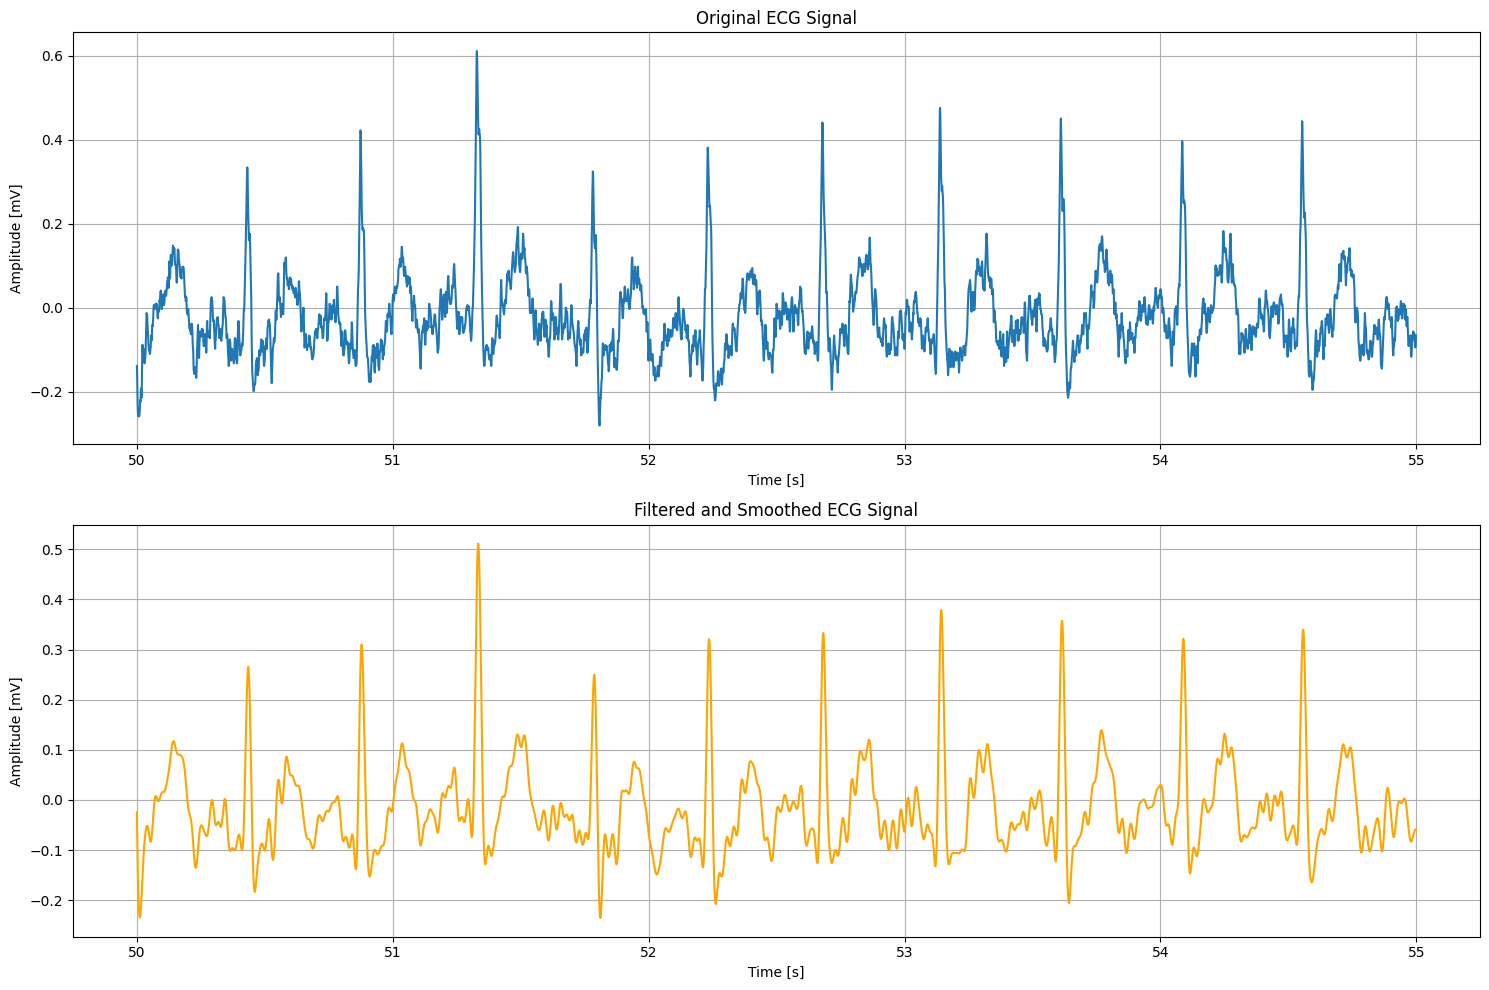

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
from scipy.signal import filtfilt, firwin, lfilter, find_peaks

# URL of the raw text file containing ECG data
#url= "https://raw.githubusercontent.com/diego-taquiri/ISB-equipo11/main/Documentaci%C3%B3n/Laboratorio%2006/ecg_raw_data/reposo/opensignals_98D341FD4F0D_2024-04-19_12-34-17.txt"
url = "https://raw.githubusercontent.com/diego-taquiri/ISB-equipo11/main/Documentaci%C3%B3n/Laboratorio%2006/ecg_raw_data/ejercicio/opensignals_98D341FD4F0D_2024-04-19_12-46-31.txt"
#url= "https://raw.githubusercontent.com/diego-taquiri/ISB-equipo11/main/Documentaci%C3%B3n/Laboratorio%2006/ecg_raw_data/paro_cardiaco/opensignals_98D341FD4F0D_2024-04-19_12-56-28.txt"

# Download the data from the URL
response = urlopen(url)
data = response.read().decode('utf-8').splitlines()

# Load data from the downloaded text file skipping the first 3 rows
x = np.loadtxt(data, skiprows=3)

# Calculate data in millivolts
data_mV = (x[:, 5] / 1024) * 3.223 - 3.223 / 2

# Generate time array in seconds
time = np.arange(len(data_mV)) / 1000

start_index = np.searchsorted(time, 50)  # Find the index corresponding to 50 seconds
end_index = np.searchsorted(time, 55)  # Find the index corresponding to 120 seconds
time = time[start_index:end_index]
data_mV = data_mV[start_index:end_index]

# Bandpass filter design (0.5 Hz to 43 Hz)
fs = 1000  # Sampling frequency
nyquist = 0.5 * fs
low_cutoff = 0.5 / nyquist
high_cutoff = 43 / nyquist

# Design FIR filter
numtaps = 101  # Number of taps in the filter
b = firwin(numtaps, [low_cutoff, high_cutoff], pass_zero=False)

# Apply zero-phase digital bandpass filter
filtered_signal = filtfilt(b, 1, data_mV)

# Moving average filter design
window_size = 5  # Window size for the moving average filter
moving_avg_filter = np.ones(window_size) / window_size

# Apply moving average filter
smoothed_signal = lfilter(moving_avg_filter, 1, filtered_signal)

# Calculate the first derivative
first_derivative = np.diff(smoothed_signal, n=1)
# Append a zero to maintain the original signal length
first_derivative = np.append(first_derivative, 0)

# Calculate the second derivative
second_derivative = np.diff(smoothed_signal, n=2)
# Append two zeros to maintain the original signal length
second_derivative = np.append(second_derivative, [0, 0])

# Combine the derivatives to form the feature signal
feature_signal = 1.3 * first_derivative + 1.1 * second_derivative

# Find the R peaks (maximum peaks) in the feature signal
peaks, _ = find_peaks(feature_signal, distance=fs/2.5, height=0.02)  # Assuming a minimum distance of 0.4 seconds between R peaks

# Extract RR intervals
RR_intervals = np.diff(time[peaks])*1000

# Plot the original, filtered, and feature signals with detected peaks
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(time, data_mV, label='Original Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [mV]')
plt.title('Original ECG Signal')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(time, smoothed_signal, label='Filtered and Smoothed Signal', color='orange')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [mV]')
plt.title('Filtered and Smoothed ECG Signal')
plt.grid()

plt.tight_layout()
plt.show()

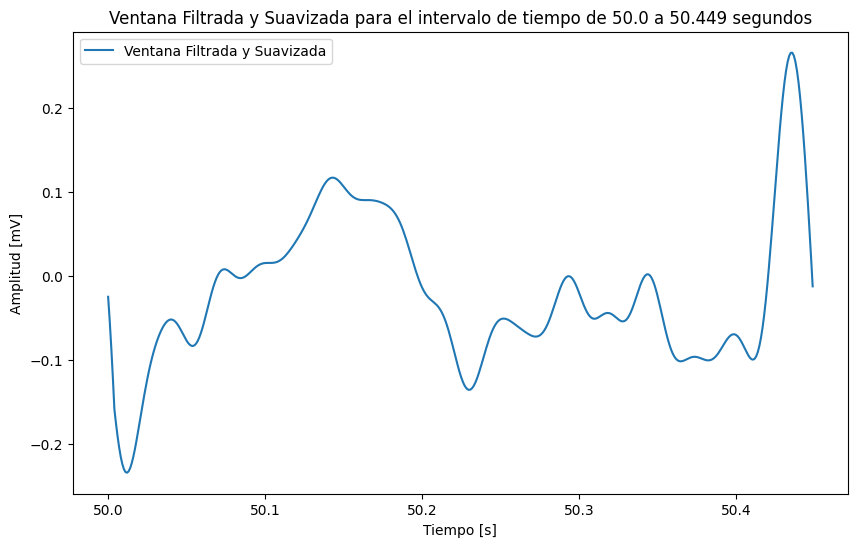

In [67]:
# Definir la duración de cada ventana en segundos y el desplazamiento (overlap)
window_length = 0.45  # longitud de la ventana en segundos
overlap = 0.3      # desplazamiento de la ventana en segundos

# Calcular el número de puntos en cada ventana
window_points = int(window_length * fs)
overlap_points = int(overlap * fs)

# Procesar cada ventana
start = 0
end = start + window_points

# Listas para almacenar resultados
filtered_signals = []
smoothed_signals = []
times = []

while end <= len(data_mV):
    # Extraer la ventana de la señal
    window_signal = data_mV[start:end]
    window_time = time[start:end]

    # Aplicar filtros como antes
    filtered_window = filtfilt(b, 1, window_signal)
    smoothed_window = lfilter(moving_avg_filter, 1, filtered_window)

    # Almacenar las señales procesadas y los tiempos
    filtered_signals.append(filtered_window)
    smoothed_signals.append(smoothed_window)
    times.append(window_time)

    # Desplazar la ventana
    start += (window_points - overlap_points)
    end = start + window_points

# Plot de una ventana específica para verificación
window_to_plot = 0  # Cambiar según qué ventana quieras visualizar

plt.figure(figsize=(10, 6))
plt.plot(times[window_to_plot], smoothed_signals[window_to_plot], label='Ventana Filtrada y Suavizada')
plt.title(f'Ventana Filtrada y Suavizada para el intervalo de tiempo de {times[window_to_plot][0]} a {times[window_to_plot][-1]} segundos')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud [mV]')
plt.legend()


In [68]:
import os
import pandas as pd

# Directorio de destino para los archivos CSV
directorio_destino = './ejercicio1'

# Crear el directorio si aún no existe
if not os.path.exists(directorio_destino):
    os.makedirs(directorio_destino)

# Iterar sobre cada ventana de señal procesada
for i, (filtered, smoothed, time_window) in enumerate(zip(filtered_signals, smoothed_signals, times)):
    # Crear un DataFrame con los datos
    datos = pd.DataFrame({
        'timestamp': time_window,
        'Señal Suavizada': smoothed
    })

    # Ruta del archivo CSV con numeración secuencial
    archivo_csv = os.path.join(directorio_destino, f'ejercicio{i + 1}.csv')

    # Guardar el DataFrame como archivo CSV
    datos.to_csv(archivo_csv, index=False)


PARO CARDIACO

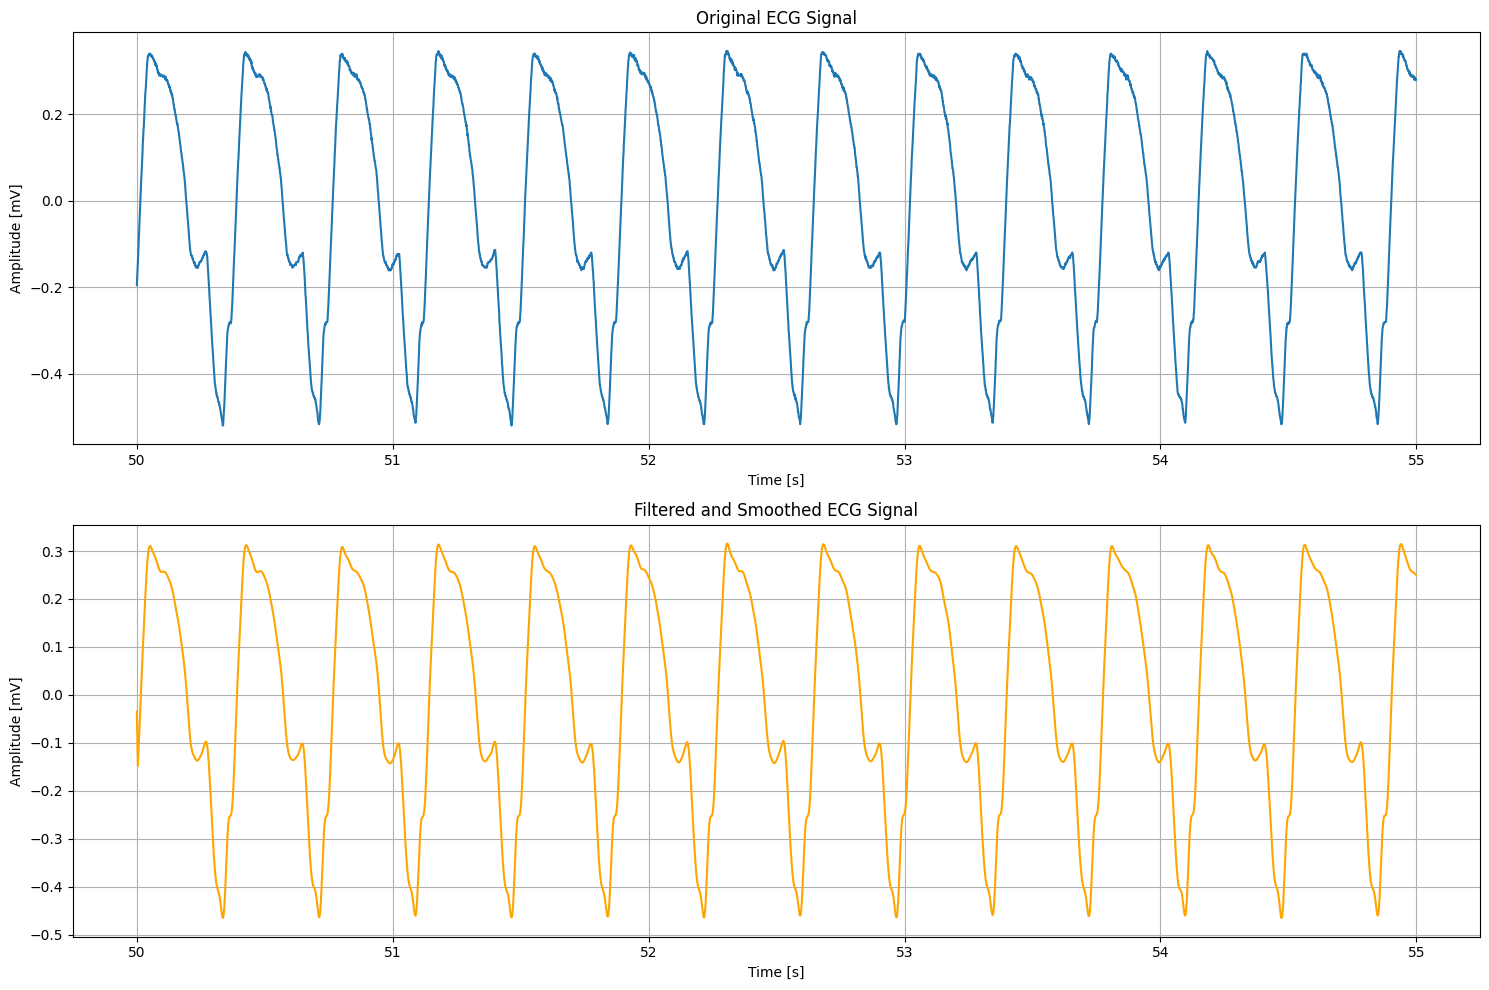

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
from scipy.signal import filtfilt, firwin, lfilter, find_peaks

# URL of the raw text file containing ECG data
#url= "https://raw.githubusercontent.com/diego-taquiri/ISB-equipo11/main/Documentaci%C3%B3n/Laboratorio%2006/ecg_raw_data/reposo/opensignals_98D341FD4F0D_2024-04-19_12-34-17.txt"
#url = "https://raw.githubusercontent.com/diego-taquiri/ISB-equipo11/main/Documentaci%C3%B3n/Laboratorio%2006/ecg_raw_data/ejercicio/opensignals_98D341FD4F0D_2024-04-19_12-46-31.txt"
url= "https://raw.githubusercontent.com/diego-taquiri/ISB-equipo11/main/Documentaci%C3%B3n/Laboratorio%2006/ecg_raw_data/paro_cardiaco/opensignals_98D341FD4F0D_2024-04-19_12-56-28.txt"

# Download the data from the URL
response = urlopen(url)
data = response.read().decode('utf-8').splitlines()

# Load data from the downloaded text file skipping the first 3 rows
x = np.loadtxt(data, skiprows=3)

# Calculate data in millivolts
data_mV = (x[:, 5] / 1024) * 3.223 - 3.223 / 2

# Generate time array in seconds
time = np.arange(len(data_mV)) / 1000

start_index = np.searchsorted(time, 50)  # Find the index corresponding to 50 seconds
end_index = np.searchsorted(time, 55)  # Find the index corresponding to 120 seconds
time = time[start_index:end_index]
data_mV = data_mV[start_index:end_index]

# Bandpass filter design (0.5 Hz to 43 Hz)
fs = 1000  # Sampling frequency
nyquist = 0.5 * fs
low_cutoff = 0.5 / nyquist
high_cutoff = 43 / nyquist

# Design FIR filter
numtaps = 101  # Number of taps in the filter
b = firwin(numtaps, [low_cutoff, high_cutoff], pass_zero=False)

# Apply zero-phase digital bandpass filter
filtered_signal = filtfilt(b, 1, data_mV)

# Moving average filter design
window_size = 5  # Window size for the moving average filter
moving_avg_filter = np.ones(window_size) / window_size

# Apply moving average filter
smoothed_signal = lfilter(moving_avg_filter, 1, filtered_signal)

# Calculate the first derivative
first_derivative = np.diff(smoothed_signal, n=1)
# Append a zero to maintain the original signal length
first_derivative = np.append(first_derivative, 0)

# Calculate the second derivative
second_derivative = np.diff(smoothed_signal, n=2)
# Append two zeros to maintain the original signal length
second_derivative = np.append(second_derivative, [0, 0])

# Combine the derivatives to form the feature signal
feature_signal = 1.3 * first_derivative + 1.1 * second_derivative

# Find the R peaks (maximum peaks) in the feature signal
peaks, _ = find_peaks(feature_signal, distance=fs/2.5, height=0.02)  # Assuming a minimum distance of 0.4 seconds between R peaks

# Extract RR intervals
RR_intervals = np.diff(time[peaks])*1000

# Plot the original, filtered, and feature signals with detected peaks
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(time, data_mV, label='Original Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [mV]')
plt.title('Original ECG Signal')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(time, smoothed_signal, label='Filtered and Smoothed Signal', color='orange')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [mV]')
plt.title('Filtered and Smoothed ECG Signal')
plt.grid()

plt.tight_layout()
plt.show()

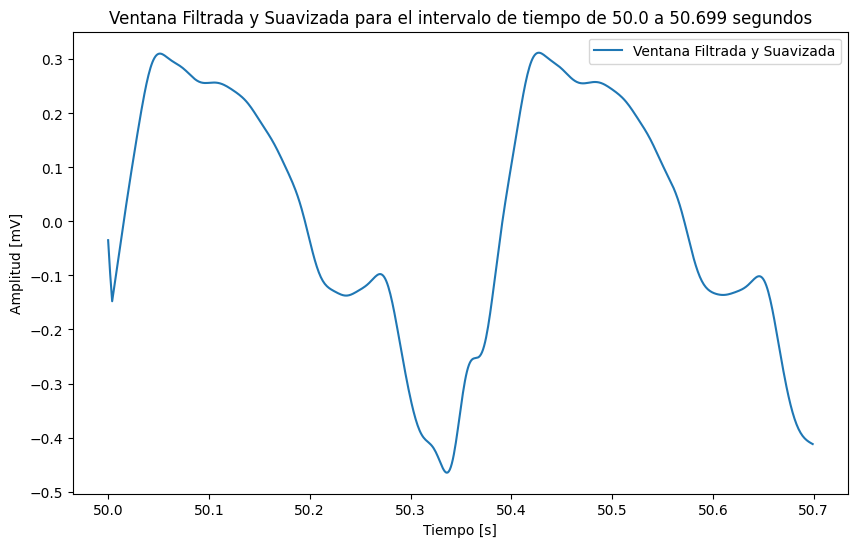

In [76]:
# Definir la duración de cada ventana en segundos y el desplazamiento (overlap)
window_length = 0.7  # longitud de la ventana en segundos
overlap = 0.5   # desplazamiento de la ventana en segundos

# Calcular el número de puntos en cada ventana
window_points = int(window_length * fs)
overlap_points = int(overlap * fs)

# Procesar cada ventana
start = 0
end = start + window_points

# Listas para almacenar resultados
filtered_signals = []
smoothed_signals = []
times = []

while end <= len(data_mV):
    # Extraer la ventana de la señal
    window_signal = data_mV[start:end]
    window_time = time[start:end]

    # Aplicar filtros como antes
    filtered_window = filtfilt(b, 1, window_signal)
    smoothed_window = lfilter(moving_avg_filter, 1, filtered_window)

    # Almacenar las señales procesadas y los tiempos
    filtered_signals.append(filtered_window)
    smoothed_signals.append(smoothed_window)
    times.append(window_time)

    # Desplazar la ventana
    start += (window_points - overlap_points)
    end = start + window_points

# Plot de una ventana específica para verificación
window_to_plot = 0  # Cambiar según qué ventana quieras visualizar

plt.figure(figsize=(10, 6))
plt.plot(times[window_to_plot], smoothed_signals[window_to_plot], label='Ventana Filtrada y Suavizada')
plt.title(f'Ventana Filtrada y Suavizada para el intervalo de tiempo de {times[window_to_plot][0]} a {times[window_to_plot][-1]} segundos')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud [mV]')
plt.legend()


In [77]:
import os
import pandas as pd

# Directorio de destino para los archivos CSV
directorio_destino = './paro2'

# Crear el directorio si aún no existe
if not os.path.exists(directorio_destino):
    os.makedirs(directorio_destino)

# Iterar sobre cada ventana de señal procesada
for i, (filtered, smoothed, time_window) in enumerate(zip(filtered_signals, smoothed_signals, times)):
    # Crear un DataFrame con los datos
    datos = pd.DataFrame({
        'timestamp': time_window,
        'Señal Suavizada': smoothed
    })

    # Ruta del archivo CSV con numeración secuencial
    archivo_csv = os.path.join(directorio_destino, f'paro{i + 1}.csv')

    # Guardar el DataFrame como archivo CSV
    datos.to_csv(archivo_csv, index=False)
